![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Inteligencia Artificial

# Practica 03

# Transformaciones, KNN vs Redes Neuronales

### Autor: Diego Tapia


## Descripción del dataset

Nombre del dataset: Statlog (German Credit Data). Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

Descripción general: Este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

**Salida**:

TIPOCLIENTE (BUENO:1, MALO:2)

### Importacion de librerias

In [8]:
# Importacion de librerias

%pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config

print("Módulos y clases importados")

Módulos y clases importados


### Carga del dataset



In [9]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Para cargar un dataframe desde una URL
dfOriginal = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ',
                         names=nombresVariables)

dataframe=copy.deepcopy(dfOriginal)
print('cantidad de observaciones (clientes): ',dataframe.shape[0])
print('cantidad de variables: ',dataframe.shape[1])
print(dataframe.shape)
dataframe.head()

cantidad de observaciones (clientes):  1000
cantidad de variables:  21
(1000, 21)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## 1. Descripción de variables del dataset

|Id	|Variable	|Descripción breve	|Tipo	|Técnica de transformación a aplicar|
----|------------|-------------------|------------|------------------------------|
|1	|ESTADOCUENTACORRIENTE	|Indica si existe o no una cuenta corriente|Categórica ordinal|Codificación binaria|
|2	|PLAZOMESESCREDITO |Duracion del prestamo en meses|	Numérica discreta	|Normalización(KNN), Estandarización(Red Neuronal)|
|3	|HISTORIALCREDITO |Historial de credito; sin credito, retraso en pagos, creditos pagados|Categórica ordinal (en el contexto del banco)|	Codificación binaria|
|4  |PROPOSITOCREDITO |Proposito del credito: auto nuevo, educacion, reparaciones, negocios, etc.|Categórica nominal| Codificación binaria|
|5  |MONTOCREDITO |Cantidad del credito|Numérica continua| Normalización(KNN), Estandarización(Red Neuronal)|
|6  |SALDOCUENTAAHORROS |Ahorros en la cuenta o límites; < 100 USD, 100 USD <X < 500 USD, 1000 USD >,desconocido |Categórica ordinal| Codificación binaria|
|7  |TIEMPOACTUALEMPLEO |Indica el tiempo  que trabaja el cliente o el estado; desempleado, < 1 año, 1año<X<4años, > 7años |Categórica ordinal| Codificación binaria|
|8  |TASAPAGO |Tasa de pago a plazos en porcentaje del ingreso disponible |Numérica continua| Normalización(KNN), Estandarización(Red Neuronal)|
|9  |ESTADOCIVILYSEXO |Indica el estado civil y sexo; hombre:divorciado, mujer:soltera: hombre:casado, ... |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|10 |GARANTE |Indica si tiene codeudores o garantes; ninguno, codeudor, garante |Categórica nominal|Codificación binaria|
|11 |TIEMPORESIDENCIAACTUAL |Tiempo de residencia en años |Numérica discreta| Normalización(KNN), Estandarización(Red Neuronal)|
|12 |ACTIVOS |activos o bienes del cliente; desconocidos, autos ,sin propiedad,bienes raices, etc. |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|13 |EDAD |Edad del cliente en años |Numérica discreta| Normalización(KNN), Estandarización(Red Neuronal)|
|14 |OTROSPLANESPAGO |Otros planes de pago del cliente; banco, tiendas, ninguno |Categórica nominal| Se elimina la variable, no se considera relevante para este análisis|
|15 |VIVIENDA |Tipo de vivienda; rentada, propia, cedida |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|16 |CANTIDADCREDITOSEXISTENTES |Número de préstamos exisentes en el banco |Numérica discreta| Normalización(KNN), Estandarización(Red Neuronal)|
|17 |EMPLEO  |Indica el estado de empleo del cliente; desempleado, trabajador no calificado,trabajador calificado, administrativo, autonomo, etc.  |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|18 |CANTIDADPERSONASAMANTENER |Número de personas de la que es responsable el cliente.  |Numérica discreta| Normalización(KNN), Estandarización(Red Neuronal)|
|19 |TELEFONO |Indica si se tiene o no registrado el numero del cliente; SI, NO  |Categórica nominal| Se elimina la variable, no se considera relevante para este análisis|
|20 |TRABAJADOREXTRANJERO |Indica si es trabajador extranjero o no; SI, NO  |Categórica nominal| Codificación binaria|
|21 |**TIPOCLIENTE** |**Variable objetivo.** Indica si es un cliente Bueno o Malo para el credito; 1: Bueno, 0: Malo  |Numérica discreta| Codificación binaria|




## 2. Modelo K Nearest Neighbor (KNN)

### Preparación de los datos




In [10]:
dfOriginal['TIPOCLIENTE'] = dfOriginal['TIPOCLIENTE'].replace(2, 0)
dfOriginal.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


#### Eliminación de variables y separación de variable de salida

Se separa la variable de salida "Y" para poder realizar la preparación de datos a las variables independiente "X"

In [11]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 21)
(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,2,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A152,1,A172,2,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A153,1,A173,2,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,2,A173,2,A201


### 2.1 KNN sin transformación de variables y sin balanceo

#### Diseño

En esta sección se evalúa el método KNN con distintos valores de parámetros. El código itera a través de diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar el rendimiento del modelo. Se calculan varias métricas de rendimiento, como: Error Absoluto Medio (MAE), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Accuracy (ACC), Precision, Recall (Sensibilidad) y F1-Score. Estas métricas miden el rendimiento del modelo en la clasificación de datos. Se ejecuta N experimentos por cada valor de K. Luego, se calcula el promedio de los N experimentos.

Se eliminan las variables categoricas del dataset

In [12]:
dataframe_datos_numericos = dataframe.select_dtypes(include='number')
dataframe_datos_numericos.head()

,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


In [13]:
# Función para transformar la predicción
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

In [14]:
# función de distancia personalizada
def distancia_personalizada(x, y):
    # Por ejemplo, aquí utilizamos la distancia Euclidiana con un peso especial
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) * 0.5

In [15]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier #KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [16]:
# Crear un DataFrame vacío con las columnas deseadas
columnas = ['DISTANCE', 'K', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

# Definir el tipo de dato de cada columna
tipos_de_variable = [str, int, float, float, float, float]

model = None

# Definir las distancias a calcular
DISTANCE = ['euclidean', 'manhattan', 'chebyshev', 'propia']

# Definir los valores de K (la cantidad de vecinos que conforman el vecindario)
K = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
valoresK = K

# Definir la cantidad de experimentos que se repiten por cada valor de K. Luego, se calculará el promedio de K experimentos
def realizar_experimentos(dataframe_datos_numericos, Y, nExperimentos):

    # Crear un DataFrame vacío, a este dataframe se agregarán fila a fila los resultados de KNN
    dataResultados = pd.DataFrame(columns=columnas)

    for idexp in range(nExperimentos):
        # Crear las particiones del conjunto de datos. De manera convencional, el conjunto de test contiene el 20% de los datos.
        X_train, X_test, y_train, y_test = train_test_split(dataframe_datos_numericos, Y, test_size=0.2)
        for d in DISTANCE:
            for k in K:
                # Llamar a la función personalizada
                if d == 'propia':
                    model = KNeighborsClassifier(n_neighbors=k, metric=distancia_personalizada)
                else:
                    model = KNeighborsClassifier(n_neighbors=k, metric=d)
                # Entrenar el modelo
                history = model.fit(X_train, y_train)
                # Calcular predicciones para el conjunto de Test
                y_pred = model.predict(X_test)
                y_pred = y_pred.flatten()
                # Transformar salida continua a discreta (binaria)
                y_pred = transformarPrediccion(y_pred)
                # Evaluar el modelo con medidas de calidad
                MAE = metrics.mean_absolute_error(y_test, y_pred)
                MSE = metrics.mean_squared_error(y_test, y_pred)
                RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                y_testBinario = (y_test >= 0.5).astype("int32")
                y_predBinario = (y_pred >= 0.5).astype("int32")
                ACC = float(str(accuracy_score(y_testBinario, y_predBinario)))
                precision = precision_score(y_testBinario, y_predBinario)
                recall = recall_score(y_testBinario, y_predBinario)
                f1 = f1_score(y_testBinario, y_predBinario)
                MAE = float(str(round(MAE, 4)))
                MSE = float(str(round(MSE, 4)))
                RMSE = float(str(round(RMSE, 4)))
                precision = float(str(round(precision, 4)))
                recall = float(str(round(recall, 4)))
                f1 = float(str(round(f1, 4)))
                valor = [d, k, ACC, precision, recall, f1]
                # print(valor)
                fila = pd.Series(valor, index=columnas)
                # Agregar los resultados en el dataframe
                dataResultados = pd.concat([dataResultados, fila.to_frame().T], ignore_index=True)

    # Convertir el tipo de datos de cada columna
    dataResultados['K'] = dataResultados['K'].astype(int)
    dataResultados['ACC'] = dataResultados['ACC'].astype(float)
    dataResultados['PRECISION'] = dataResultados['PRECISION'].astype(float)
    dataResultados['RECALL'] = dataResultados['RECALL'].astype(float)
    dataResultados['F1-SCORE'] = dataResultados['F1-SCORE'].astype(float)
    dataResultados = dataResultados.sort_values(by=['DISTANCE', 'K'])
    dataResultados = dataResultados.reset_index(drop=True)

    return dataResultados


Resultados con 5 experimentos

In [17]:
resultados_5_exp = realizar_experimentos(dataframe_datos_numericos, Y, 5)
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.700,0.7425,0.8794,0.8052
1,chebyshev,10,0.645,0.7037,0.8321,0.7625
2,chebyshev,10,0.715,0.7485,0.8841,0.8106
3,chebyshev,10,0.660,0.7333,0.8345,0.7806
4,chebyshev,10,0.630,0.6871,0.8296,0.7517


Resultados con 10 experimentos

In [18]:
resultados_10_exp = realizar_experimentos(dataframe_datos_numericos, Y, 10)
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.670,0.7101,0.8759,0.7843
1,chebyshev,10,0.635,0.7205,0.8056,0.7607
2,chebyshev,10,0.675,0.7125,0.8571,0.7782
3,chebyshev,10,0.635,0.6860,0.8613,0.7638
4,chebyshev,10,0.680,0.7438,0.8380,0.7881


Resultados con 20 experimentos

In [19]:
resultados_20_exp = realizar_experimentos(dataframe_datos_numericos, Y, 20)
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.670,0.7362,0.8392,0.7843
1,chebyshev,10,0.620,0.6975,0.8071,0.7483
2,chebyshev,10,0.620,0.6859,0.7985,0.7379
3,chebyshev,10,0.610,0.6707,0.8209,0.7383
4,chebyshev,10,0.645,0.6746,0.8769,0.7625


Resultados con 30 experimentos

In [20]:
resultados_30_exp = realizar_experimentos(dataframe_datos_numericos, Y, 30)
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.635,0.6890,0.8370,0.7559
1,chebyshev,10,0.680,0.7405,0.8357,0.7852
2,chebyshev,10,0.655,0.7516,0.7973,0.7738
3,chebyshev,10,0.645,0.7134,0.8298,0.7672
4,chebyshev,10,0.670,0.7358,0.8298,0.7800


#### Agrupar resultados por medida de distancia y cantidad de vecinos (K)


Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

**Agrupación con 5 experimentos**

In [21]:
resultados_5_exp = resultados_5_exp.groupby(['DISTANCE','K'])
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.700,0.7425,0.8794,0.8052
1,chebyshev,10,0.645,0.7037,0.8321,0.7625
2,chebyshev,10,0.715,0.7485,0.8841,0.8106
3,chebyshev,10,0.660,0.7333,0.8345,0.7806
4,chebyshev,10,0.630,0.6871,0.8296,0.7517
...,...,...,...,...,...,...
195,propia,100,0.705,0.7050,1.0000,0.8270
196,propia,100,0.685,0.6850,1.0000,0.8131
197,propia,100,0.690,0.6900,1.0000,0.8166
198,propia,100,0.725,0.7250,1.0000,0.8406


Se calcula el promedio de los 5 experimentos

In [22]:

resultados_5_exp = resultados_5_exp.mean()
resultados_5_exp = resultados_5_exp.reset_index()
resultados_5_exp = resultados_5_exp.reset_index(drop=True)
resultados_5_exp = resultados_5_exp.groupby(['DISTANCE'])
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.670,0.72302,0.85194,0.78212
1,chebyshev,20,0.689,0.71458,0.92084,0.80458
2,chebyshev,30,0.696,0.70938,0.95208,0.81296
3,chebyshev,40,0.701,0.70880,0.96652,0.81776
4,chebyshev,50,0.701,0.70822,0.96950,0.81820
10,euclidean,10,0.672,0.72598,0.84918,0.78262
11,euclidean,20,0.686,0.71272,0.91948,0.80286
12,euclidean,30,0.696,0.70938,0.95208,0.81296
13,euclidean,40,0.701,0.70880,0.96652,0.81776
14,euclidean,50,0.701,0.70822,0.96950,0.81820


**Agrupación con 10 experimentos**



In [23]:
resultados_10_exp = resultados_10_exp.groupby(['DISTANCE','K'])
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.670,0.7101,0.8759,0.7843
1,chebyshev,10,0.635,0.7205,0.8056,0.7607
2,chebyshev,10,0.675,0.7125,0.8571,0.7782
3,chebyshev,10,0.635,0.6860,0.8613,0.7638
4,chebyshev,10,0.680,0.7438,0.8380,0.7881
...,...,...,...,...,...,...
390,propia,100,0.685,0.6850,1.0000,0.8131
391,propia,100,0.720,0.7200,1.0000,0.8372
392,propia,100,0.665,0.6650,1.0000,0.7988
393,propia,100,0.685,0.6850,1.0000,0.8131


Se calcula el promedio de los 10 experimentos

In [24]:
resultados_10_exp = resultados_10_exp.mean()
resultados_10_exp = resultados_10_exp.reset_index()
resultados_10_exp = resultados_10_exp.reset_index(drop=True)
resultados_10_exp = resultados_10_exp.groupby(['DISTANCE'])
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.6530,0.71616,0.83364,0.76984
1,chebyshev,20,0.6895,0.71157,0.93378,0.80720
2,chebyshev,30,0.7060,0.71155,0.97276,0.82156
3,chebyshev,40,0.7115,0.71160,0.98565,0.82625
4,chebyshev,50,0.7075,0.70885,0.98495,0.82414
10,euclidean,10,0.6545,0.71710,0.83438,0.77075
11,euclidean,20,0.6910,0.71295,0.93301,0.80782
12,euclidean,30,0.7060,0.71155,0.97276,0.82156
13,euclidean,40,0.7115,0.71160,0.98565,0.82625
14,euclidean,50,0.7075,0.70885,0.98495,0.82414


**Agrupación con 20 experimentos**

In [25]:
resultados_20_exp = resultados_20_exp.groupby(['DISTANCE','K'])
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.670,0.7362,0.8392,0.7843
1,chebyshev,10,0.620,0.6975,0.8071,0.7483
2,chebyshev,10,0.620,0.6859,0.7985,0.7379
3,chebyshev,10,0.610,0.6707,0.8209,0.7383
4,chebyshev,10,0.645,0.6746,0.8769,0.7625
...,...,...,...,...,...,...
780,propia,100,0.715,0.7150,1.0000,0.8338
781,propia,100,0.700,0.7000,1.0000,0.8235
782,propia,100,0.670,0.6700,1.0000,0.8024
783,propia,100,0.670,0.6700,1.0000,0.8024


Se calcula el promedio de los 20 experimentos

In [26]:
resultados_20_exp = resultados_20_exp.mean()
resultados_20_exp = resultados_20_exp.reset_index()
resultados_20_exp = resultados_20_exp.reset_index(drop=True)
resultados_20_exp = resultados_20_exp.groupby(['DISTANCE'])
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.65425,0.719035,0.836080,0.772480
1,chebyshev,20,0.68400,0.714640,0.917865,0.802945
2,chebyshev,30,0.70075,0.714165,0.958590,0.818030
3,chebyshev,40,0.70575,0.714335,0.969490,0.822095
4,chebyshev,50,0.70725,0.714055,0.974120,0.823565
10,euclidean,10,0.66025,0.721410,0.843440,0.777040
11,euclidean,20,0.68475,0.714700,0.919190,0.803565
12,euclidean,30,0.70050,0.714090,0.958235,0.817845
13,euclidean,40,0.70625,0.714460,0.970150,0.822430
14,euclidean,50,0.70725,0.714055,0.974120,0.823565


**Agrupación con 30 experimentos**

In [27]:
resultados_30_exp = resultados_30_exp.groupby(['DISTANCE','K'])
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.635,0.6890,0.8370,0.7559
1,chebyshev,10,0.680,0.7405,0.8357,0.7852
2,chebyshev,10,0.655,0.7516,0.7973,0.7738
3,chebyshev,10,0.645,0.7134,0.8298,0.7672
4,chebyshev,10,0.670,0.7358,0.8298,0.7800
...,...,...,...,...,...,...
1170,propia,100,0.675,0.6750,1.0000,0.8060
1171,propia,100,0.700,0.7000,1.0000,0.8235
1172,propia,100,0.740,0.7424,0.9932,0.8497
1173,propia,100,0.705,0.7050,1.0000,0.8270


Se calcula el promedio de los 30 experimentos

In [28]:
resultados_30_exp = resultados_30_exp.mean()
resultados_30_exp = resultados_30_exp.reset_index()
resultados_30_exp = resultados_30_exp.reset_index(drop=True)
resultados_30_exp = resultados_30_exp.groupby(['DISTANCE'])
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.653000,0.715717,0.839247,0.771570
1,chebyshev,20,0.680167,0.708750,0.923640,0.801347
2,chebyshev,30,0.697500,0.710140,0.961513,0.816223
3,chebyshev,40,0.701333,0.710080,0.971003,0.819617
4,chebyshev,50,0.701500,0.708573,0.976203,0.820507
10,euclidean,10,0.655000,0.716970,0.840977,0.773007
11,euclidean,20,0.680833,0.709217,0.923877,0.801707
12,euclidean,30,0.698500,0.710520,0.962707,0.816913
13,euclidean,40,0.701500,0.710060,0.971500,0.819787
14,euclidean,50,0.701667,0.708610,0.976420,0.820620


#### Visualización de resultados

Visualización de Resultados  con 5 experimentos

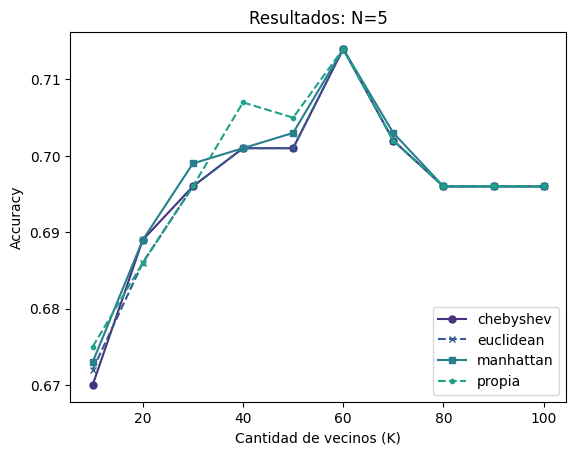

In [29]:

sns.set_palette("viridis")
for name in resultados_5_exp.groups.keys():
    group = resultados_5_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=5")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

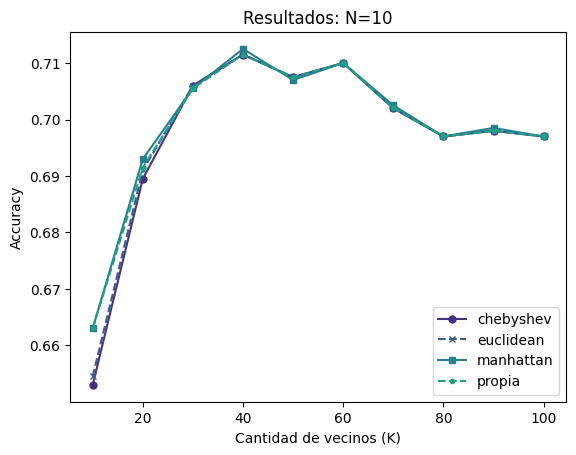

In [30]:
for name in resultados_10_exp.groups.keys():
    group = resultados_10_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=10")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

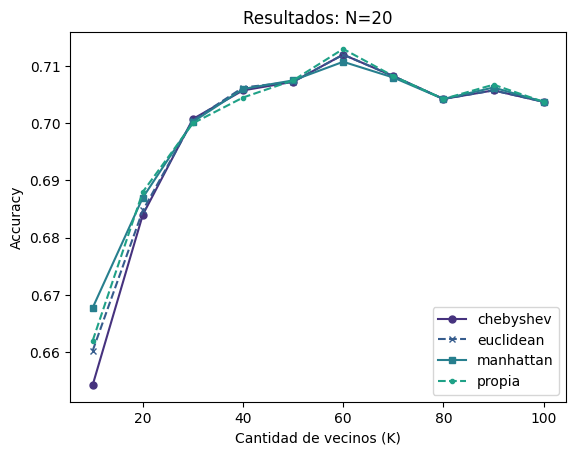

In [31]:
for name in resultados_20_exp.groups.keys():
    group = resultados_20_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=20")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

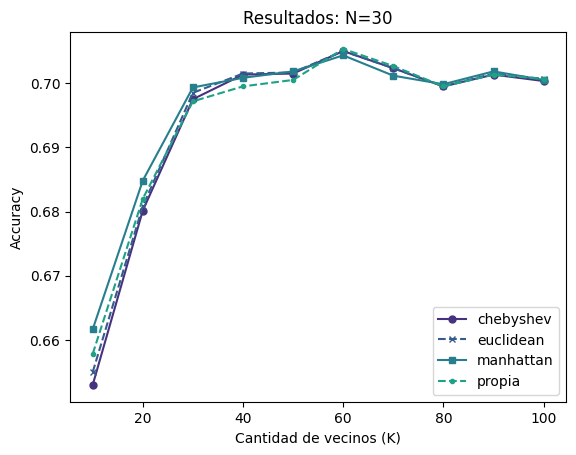

In [32]:
for name in resultados_30_exp.groups.keys():
    group = resultados_30_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=30")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

#### **Mejores valores de K**
Se presentan los valores de K con el "accuracy" mas alto

Mejor valor de K con 5 experimentos:

In [33]:
# Convertir DataFrameGroupBy a DataFrame regular
resultados_5_exp = resultados_5_exp.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_5 = resultados_5_exp.loc[resultados_5_exp['ACC'].idxmax()]
mejor_k_5 = fila_mejor_k_5['K']
mejor_acc_5 = fila_mejor_k_5['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_5}")
print(f"El mejor ACC es: {mejor_acc_5}")

El valor de K con el mejor ACC es: 60
El mejor ACC es: 0.714


Mejor valor de K con 10 experimentos:

In [34]:
resultados_10_exp = resultados_10_exp.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_10 = resultados_10_exp.loc[resultados_10_exp['ACC'].idxmax()]
mejor_k_10 = fila_mejor_k_10['K']
mejor_acc_10 = fila_mejor_k_10['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_10}")
print(f"El mejor ACC es: {mejor_acc_10}")

El valor de K con el mejor ACC es: 40
El mejor ACC es: 0.7125


Mejor valor de K con 20 experimentos:

In [35]:
resultados_20_exp = resultados_20_exp.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_20 = resultados_20_exp.loc[resultados_20_exp['ACC'].idxmax()]
mejor_k_20 = fila_mejor_k_20['K']
mejor_acc_20 = fila_mejor_k_20['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_20}")
print(f"El mejor ACC es: {mejor_acc_20}")

El valor de K con el mejor ACC es: 60
El mejor ACC es: 0.713


Mejor valor de K con 30 experimentos:

In [36]:
resultados_30_exp = resultados_30_exp.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_30 = resultados_30_exp.loc[resultados_30_exp['ACC'].idxmax()]
mejor_k_30 = fila_mejor_k_30['K']
mejor_acc_30 = fila_mejor_k_30['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_30}")
print(f"El mejor ACC es: {mejor_acc_30}")

El valor de K con el mejor ACC es: 60
El mejor ACC es: 0.7053333333333334


**Resumen resultados mejor K y ACC**

In [37]:
print("resumen mejores K y ACC")
print(f"Mejor K y acc con 5 experimentos: K= {mejor_k_5}, acc= {mejor_acc_5}")
print(f"Mejor K y acc con 10 experimentos: K= {mejor_k_10}, acc= {mejor_acc_10}")
print(f"Mejor K y acc con 20 experimentos: K= {mejor_k_20}, acc= {mejor_acc_20}")
print(f"Mejor K y acc con 30 experimentos: K= {mejor_k_30}, acc= {mejor_acc_30}")

resumen mejores K y ACC
Mejor K y acc con 5 experimentos: K= 60, acc= 0.714
Mejor K y acc con 10 experimentos: K= 40, acc= 0.7125
Mejor K y acc con 20 experimentos: K= 60, acc= 0.713
Mejor K y acc con 30 experimentos: K= 60, acc= 0.7053333333333334


#### **Mejor K**
A partir de los resultados anteriores se selecciona el "mejor K":
 **K = 50** con un accuracy **ACC = 0.7145**

### Modelo optimizado con el mejor K

Se entrena el modelo con el mejor K seleccionado (K=50) y con la mejor distancia: "manhattan"



In [38]:
#Construcción de modelo KNN
modelo_sin_transformacion=KNeighborsRegressor(n_neighbors=50, metric='manhattan')
X_train, X_test, y_train, y_test = train_test_split(dataframe_datos_numericos, Y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
modelo_sin_transformacion.fit(X_train, y_train)
print('Modelo entrenado')

(800, 7) (800,)
(200, 7) (200,)
Modelo entrenado


### Predicción del modelo sin transformación con el conjunto de Test

In [39]:
y_pred = modelo_sin_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_sin_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_sin_transformacion.head(10)

,real,predicción clase
803,1,1.0
908,1,1.0
849,0,1.0
164,1,1.0
927,0,1.0
744,1,1.0
668,0,1.0
986,1,1.0
670,1,1.0
92,0,1.0


### Evaluación de la calidad del modelo

Mean Absolute Error (MAE): 0.315
Mean Squared Error (MSE): 0.315
Root Mean Squared Error (RMSE): 0.5612
Accuracy: 0.685
Precision:  0.685
Recall:  1.0
F1: 0.8131
Matriz de confusión:
Verdaderos negativos:  0  Falsos positivos:  63  Falsos negativos:  0  Verdaderos positivos:  137


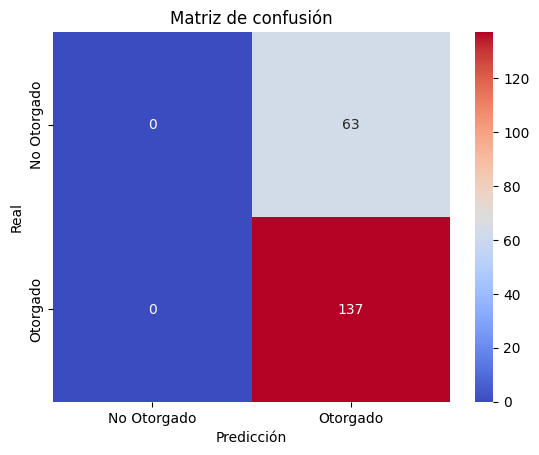

In [40]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

## 2.2 KNN con transformacion de variables.

Ahora para usar KNN se considera las variables categóricas nominales y ordinales.

In [41]:
dataframe_con_variables_categoricas = copy.deepcopy(dataframe)

### Análisis de variables categóricas

In [42]:
#Determinación de tipos de variables
categorical_ordinal_features = ['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO',
                                'ESTADOCIVILYSEXO','ACTIVOS','VIVIENDA','EMPLEO']
categorical_nominal_features = ['PROPOSITOCREDITO','GARANTE','TRABAJADOREXTRANJERO']
numeric_features = ['PLAZOMESESCREDITO','MONTOCREDITO','TASAPAGO','TIEMPORESIDENCIAACTUAL','EDAD','CANTIDADCREDITOSEXISTENTES',
                    'CANTIDADPERSONASAMANTENER']

In [43]:
def analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features):
    cantidadTotalVariables = len(dataframe.columns)
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadCategorias=dataframe[variable].nunique()
        cantidadVariablesBinarias=cantidadVariablesBinarias+cantidadCategorias
        print('Cantidad de categorías en la variable categórica nominal',variable,':',cantidadCategorias)
    print('Cantidad de variables binarias que reemplazarán a las variables categóricas nominales: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    return cantidadTotalVariablesConTransformacion

In [44]:
cantidadTotalVariablesConTransformacion=analisisVariables(dataframe_con_variables_categoricas, categorical_ordinal_features, categorical_nominal_features)
print('Cantidad de variables que habrá después de la transformación de variables: ',cantidadTotalVariablesConTransformacion)

Cantidad de variables antes de transformación de variables:  18
Cantidad de categorías en la variable categórica nominal PROPOSITOCREDITO : 10
Cantidad de categorías en la variable categórica nominal GARANTE : 3
Cantidad de categorías en la variable categórica nominal TRABAJADOREXTRANJERO : 2
Cantidad de variables binarias que reemplazarán a las variables categóricas nominales:  15
Cantidad de variables que habrá después de la transformación de variables:  30


### Diseño de transformadores


Por medio de un Pipeline creamos un estimador compuesto. Esta herramienta nos permite combinar preprocesadores y transformadores para llevar un orden y estructura en el proceso de transformación de variables. Para una mejor organización creamos los preprocesadores y sus métodos de transformación.

In [45]:
#Definición de transformadores (preprocesadores)

#1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])
categorical_nominal_transformer_ConNombres = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
preprocesorCategoricoNumericoConNombres = ColumnTransformer(
    transformers=[
        ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
        ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
    ],remainder='passthrough',n_jobs=-1)

#2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocesorMinMax = ColumnTransformer(transformers =[
    ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
standardscaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True,with_std=True))])
preprocesorStandardScaler = ColumnTransformer(transformers =[
    ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#4. Preprocesador de variables numéricas con transformación SimpleImputer
simpleimputer_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')) #otras: strategy='constant', strategy='most_frequent'
])
preprocesorSimpleImputer = ColumnTransformer(transformers =[
('transimpleimputer', simpleimputer_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

### Diseño de pipeline

El procesador 'prepcn' es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline "pipe" se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica.

In [46]:
#Construcción de Pipeline con transformadores
pipe = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres),
    ('prepminmax', preprocesorMinMax)
])

### Transformación de variables

Se ejecuta el pipeline

In [47]:

X_Transformado = pipe.fit_transform(dataframe_con_variables_categoricas)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn"
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1]
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Lista de variables:')
print(cnamesDataset1)
dataframe_transformado_KNN = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
#Guardar el dataset sin etiquetas como csv
#dataframe_transformado_KNN.to_csv("DatasetTransformadoSinEtiquetas.csv", sep=";",index = False)
#Se agrega la variable de salida (etiquetas) al final
dataframe_transformado_KNN = pd.concat([dataframe_transformado_KNN, Y], axis = 1)
#Guardar el dataset con etiquetas como csv
#dataframe_transformado_KNN.to_csv("DatasetTransformadoConEtiquetas.csv", sep=";",index = False)
dataframe_transformado_KNN.head()

********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['PROPOSITOCREDITO', 'GARANTE', 'TRABAJADOREXTRANJERO'])
********** Lista de variables:
['ESTADOCUENTACORRIENTE', 'HISTORIALCREDITO', 'SALDOCUENTAAHORROS', 'TIEMPOACTUALEMPLEO', 'ESTADOCIVILYSEXO', 'ACTIVOS', 'VIVIENDA', 'EMPLEO', 'PROPOSITOCREDITO_A40', 'PROPOSITOCREDITO_A41', 'PROPOSITOCREDITO_A410', 'PROPOSITOCREDITO_A42', 'PROPOSITOCREDITO_A43', 'PROPOSITOCREDITO_A44', 'PROPOSITOCREDITO_A45', 'PROPOSITOCREDITO_A46', 'PROPOSITOCREDITO_A48', 'PROPOSITOCREDITO_A49', 'GARANTE_A101', 'GARANTE_A102', 'GARANTE_A103', 'TRABAJADOREXTRANJERO_A201', 'TRABAJADOREXTRANJERO_A202', 'PLAZOMESESCREDITO', 'MONTOCREDITO', 'TASAPAGO', 'TIEMPORESIDENCIAACTUAL', 'EDAD', 'CANTIDADCREDITOSEXISTENTES', 'CANTIDADPERSONASAMANTENER']


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0


In [48]:
# Pipeline
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

### Diseño y optimización del modelo KNN con transformacion de variables

En esta sección se evalúa el método KNN con distintos valores de parámetros. El código itera a través de diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar el rendimiento del modelo. Se calculan varias métricas de rendimiento, como: Error Absoluto Medio (MAE), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Accuracy (ACC), Precision, Recall (Sensibilidad) y F1-Score. Estas métricas miden el rendimiento del modelo en la clasificación de datos. Se ejecuta N experimentos por cada valor de K. Luego, se calcula el promedio de los N experimentos.

In [49]:
Y = dataframe_transformado_KNN['TIPOCLIENTE']
dataframe_transformado_KNN = dataframe_transformado_KNN.drop(['TIPOCLIENTE'], axis=1)
dataframe_transformado_KNN.head()


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,GARANTE_A103,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,0.0,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0


In [50]:
# Crear un DataFrame vacío con las columnas deseadas
columnas = ['DISTANCE', 'K', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

# Definir el tipo de dato de cada columna
tipos_de_variable = [str, int, float, float, float, float]

model = None

# Definir las distancias a calcular
DISTANCE = ['euclidean', 'manhattan', 'chebyshev', 'propia']

# Definir los valores de K (la cantidad de vecinos que conforman el vecindario)
K = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
valoresK = K

# Definir la cantidad de experimentos que se repiten por cada valor de K. Luego, se calculará el promedio de K experimentos
def realizar_experimentos_con_transformacion(dataframe_transformado_KNN, Y, nExperimentos):

    # Crear un DataFrame vacío, a este dataframe se agregarán fila a fila los resultados de KNN
    dataResultados = pd.DataFrame(columns=columnas)

    for idexp in range(nExperimentos):
        # Crear las particiones del conjunto de datos. De manera convencional, el conjunto de test contiene el 20% de los datos.
        X_train, X_test, y_train, y_test = train_test_split(dataframe_transformado_KNN, Y, test_size=0.2)
        for d in DISTANCE:
            for k in K:
                # Llamar a la función personalizada
                if d == 'propia':
                    model = KNeighborsClassifier(n_neighbors=k, metric=distancia_personalizada)
                else:
                    model = KNeighborsClassifier(n_neighbors=k, metric=d)
                # Entrenar el modelo
                history = model.fit(X_train, y_train)
                # Calcular predicciones para el conjunto de Test
                y_pred = model.predict(X_test)
                y_pred = y_pred.flatten()
                # Transformar salida continua a discreta (binaria)
                y_pred = transformarPrediccion(y_pred)
                # Evaluar el modelo con medidas de calidad
                MAE = metrics.mean_absolute_error(y_test, y_pred)
                MSE = metrics.mean_squared_error(y_test, y_pred)
                RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                y_testBinario = (y_test >= 0.5).astype("int32")
                y_predBinario = (y_pred >= 0.5).astype("int32")
                ACC = float(str(accuracy_score(y_testBinario, y_predBinario)))
                precision = precision_score(y_testBinario, y_predBinario)
                recall = recall_score(y_testBinario, y_predBinario)
                f1 = f1_score(y_testBinario, y_predBinario)
                MAE = float(str(round(MAE, 4)))
                MSE = float(str(round(MSE, 4)))
                RMSE = float(str(round(RMSE, 4)))
                precision = float(str(round(precision, 4)))
                recall = float(str(round(recall, 4)))
                f1 = float(str(round(f1, 4)))
                valor = [d, k, ACC, precision, recall, f1]
                # print(valor)
                fila = pd.Series(valor, index=columnas)
                # Agregar los resultados en el dataframe
                dataResultados = pd.concat([dataResultados, fila.to_frame().T], ignore_index=True)

    # Convertir el tipo de datos de cada columna
    dataResultados['K'] = dataResultados['K'].astype(int)
    dataResultados['ACC'] = dataResultados['ACC'].astype(float)
    dataResultados['PRECISION'] = dataResultados['PRECISION'].astype(float)
    dataResultados['RECALL'] = dataResultados['RECALL'].astype(float)
    dataResultados['F1-SCORE'] = dataResultados['F1-SCORE'].astype(float)
    dataResultados = dataResultados.sort_values(by=['DISTANCE', 'K'])
    dataResultados = dataResultados.reset_index(drop=True)

    return dataResultados

Resultados con 5 experimentos con datos transformados

In [51]:
resultados_5_exp_transformado = realizar_experimentos_con_transformacion(dataframe_transformado_KNN, Y, 5)
resultados_5_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.695,0.7375,0.8613,0.7946
1,chebyshev,10,0.670,0.7143,0.8696,0.7843
2,chebyshev,10,0.725,0.7658,0.8705,0.8148
3,chebyshev,10,0.705,0.7436,0.8593,0.7973
4,chebyshev,10,0.740,0.7654,0.8986,0.8267


Resultados con 10 experimentos con datos transformados

In [52]:
resultados_10_exp_transformado = realizar_experimentos_con_transformacion(dataframe_transformado_KNN, Y, 10)
resultados_10_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.735,0.7935,0.8542,0.8227
1,chebyshev,10,0.635,0.8174,0.6438,0.7203
2,chebyshev,10,0.740,0.7574,0.9209,0.8312
3,chebyshev,10,0.655,0.7070,0.8284,0.7629
4,chebyshev,10,0.695,0.7546,0.8542,0.8013


Resultados con 20 experimentos con datos transformados

In [53]:
resultados_20_exp_transformado = realizar_experimentos_con_transformacion(dataframe_transformado_KNN, Y, 20)
resultados_20_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.730,0.7697,0.8881,0.8247
1,chebyshev,10,0.735,0.7706,0.9034,0.8317
2,chebyshev,10,0.680,0.6897,0.9231,0.7895
3,chebyshev,10,0.695,0.7202,0.8963,0.7987
4,chebyshev,10,0.600,0.7087,0.6767,0.6923


Resultados con 30 experimentos con datos transformados

In [54]:
resultados_30_exp_transformado = realizar_experimentos_con_transformacion(dataframe_transformado_KNN, Y, 30)
resultados_30_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.700,0.7239,0.8872,0.7973
1,chebyshev,10,0.725,0.7651,0.8881,0.8220
2,chebyshev,10,0.750,0.8235,0.8456,0.8344
3,chebyshev,10,0.735,0.7831,0.8844,0.8307
4,chebyshev,10,0.700,0.7235,0.9044,0.8039


### Agrupar resultados por medida de distancia y cantidad de vecinos (K)

Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

**Agrupación con 5 experimentos**

In [55]:
resultados_5_exp_transformado = resultados_5_exp_transformado.groupby(['DISTANCE','K'])
resultados_5_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.695,0.7375,0.8613,0.7946
1,chebyshev,10,0.670,0.7143,0.8696,0.7843
2,chebyshev,10,0.725,0.7658,0.8705,0.8148
3,chebyshev,10,0.705,0.7436,0.8593,0.7973
4,chebyshev,10,0.740,0.7654,0.8986,0.8267
...,...,...,...,...,...,...
195,propia,100,0.735,0.7763,0.8613,0.8166
196,propia,100,0.705,0.7484,0.8623,0.8013
197,propia,100,0.715,0.7628,0.8561,0.8068
198,propia,100,0.690,0.6931,0.9704,0.8086


Se calcula el promedio de los 5 experimentos

In [56]:
resultados_5_exp_transformado = resultados_5_exp_transformado.mean()
resultados_5_exp_transformado = resultados_5_exp_transformado.reset_index()
resultados_5_exp_transformado = resultados_5_exp_transformado.reset_index(drop=True)
resultados_5_exp_transformado = resultados_5_exp_transformado.groupby(['DISTANCE'])
resultados_5_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.707,0.74532,0.87186,0.80354
1,chebyshev,20,0.715,0.73170,0.92434,0.81670
2,chebyshev,30,0.694,0.70588,0.95054,0.81010
3,chebyshev,40,0.703,0.70986,0.96076,0.81630
4,chebyshev,50,0.702,0.70216,0.98400,0.81940
10,euclidean,10,0.725,0.77272,0.85014,0.80930
11,euclidean,20,0.715,0.74894,0.88080,0.80932
12,euclidean,30,0.736,0.75300,0.91722,0.82664
13,euclidean,40,0.730,0.74072,0.93462,0.82614
14,euclidean,50,0.725,0.73314,0.94334,0.82482


Agrupación con 10 experimentos

In [57]:
resultados_10_exp_transformado = resultados_10_exp_transformado.groupby(['DISTANCE','K'])
resultados_10_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.735,0.7935,0.8542,0.8227
1,chebyshev,10,0.635,0.8174,0.6438,0.7203
2,chebyshev,10,0.740,0.7574,0.9209,0.8312
3,chebyshev,10,0.655,0.7070,0.8284,0.7629
4,chebyshev,10,0.695,0.7546,0.8542,0.8013
...,...,...,...,...,...,...
390,propia,100,0.740,0.7875,0.8750,0.8289
391,propia,100,0.740,0.7500,0.9658,0.8443
392,propia,100,0.740,0.7351,0.9784,0.8395
393,propia,100,0.705,0.6963,0.9925,0.8185


Se calcula el promedio de los 10 experimentos

In [58]:
resultados_10_exp_transformado = resultados_10_exp_transformado.mean()
resultados_10_exp_transformado = resultados_10_exp_transformado.reset_index()
resultados_10_exp_transformado = resultados_10_exp_transformado.reset_index(drop=True)
resultados_10_exp_transformado = resultados_10_exp_transformado.groupby(['DISTANCE'])
resultados_10_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.6990,0.75273,0.84855,0.79491
1,chebyshev,20,0.7110,0.73314,0.91850,0.81487
2,chebyshev,30,0.7130,0.72314,0.95015,0.82091
3,chebyshev,40,0.7065,0.71642,0.95523,0.81838
4,chebyshev,50,0.7035,0.70827,0.97415,0.81988
10,euclidean,10,0.7055,0.76275,0.83501,0.79696
11,euclidean,20,0.7225,0.75682,0.88506,0.81525
12,euclidean,30,0.7280,0.75077,0.91216,0.82286
13,euclidean,40,0.7135,0.73416,0.92291,0.81697
14,euclidean,50,0.7190,0.73093,0.94263,0.82290


Agrupación con 20 experimentos

In [59]:
resultados_20_exp_transformado = resultados_20_exp_transformado.groupby(['DISTANCE','K'])
resultados_20_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.730,0.7697,0.8881,0.8247
1,chebyshev,10,0.735,0.7706,0.9034,0.8317
2,chebyshev,10,0.680,0.6897,0.9231,0.7895
3,chebyshev,10,0.695,0.7202,0.8963,0.7987
4,chebyshev,10,0.600,0.7087,0.6767,0.6923
...,...,...,...,...,...,...
780,propia,100,0.730,0.7330,0.9790,0.8383
781,propia,100,0.740,0.7784,0.8966,0.8333
782,propia,100,0.680,0.7171,0.8385,0.7730
783,propia,100,0.690,0.6931,0.9704,0.8086


Se calcula el promedio de los 20 experimentos

In [60]:
resultados_20_exp_transformado = resultados_20_exp_transformado.mean()
resultados_20_exp_transformado = resultados_20_exp_transformado.reset_index()
resultados_20_exp_transformado = resultados_20_exp_transformado.reset_index(drop=True)
resultados_20_exp_transformado = resultados_20_exp_transformado.groupby(['DISTANCE'])
resultados_20_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.68975,0.749620,0.835300,0.787725
1,chebyshev,20,0.70525,0.735830,0.904015,0.809545
2,chebyshev,30,0.71325,0.724850,0.951190,0.821930
3,chebyshev,40,0.71025,0.717675,0.966405,0.822800
4,chebyshev,50,0.70775,0.712025,0.978150,0.823330
10,euclidean,10,0.71950,0.775095,0.843045,0.806980
11,euclidean,20,0.72475,0.762560,0.881005,0.816665
12,euclidean,30,0.72750,0.750940,0.914140,0.823575
13,euclidean,40,0.72775,0.743735,0.932395,0.826645
14,euclidean,50,0.72475,0.737470,0.942055,0.826535


Agrupación con 30 experimentos

In [61]:
resultados_30_exp_transformado = resultados_30_exp_transformado.groupby(['DISTANCE','K'])
resultados_30_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.700,0.7239,0.8872,0.7973
1,chebyshev,10,0.725,0.7651,0.8881,0.8220
2,chebyshev,10,0.750,0.8235,0.8456,0.8344
3,chebyshev,10,0.735,0.7831,0.8844,0.8307
4,chebyshev,10,0.700,0.7235,0.9044,0.8039
...,...,...,...,...,...,...
1170,propia,100,0.685,0.6842,0.9774,0.8050
1171,propia,100,0.760,0.7879,0.9091,0.8442
1172,propia,100,0.770,0.8084,0.9060,0.8544
1173,propia,100,0.725,0.7840,0.8639,0.8220


Se calcula el promedio de los 30 experimentos

In [62]:
resultados_30_exp_transformado = resultados_30_exp_transformado.mean()
resultados_30_exp_transformado = resultados_30_exp_transformado.reset_index()
resultados_30_exp_transformado = resultados_30_exp_transformado.reset_index(drop=True)
resultados_30_exp_transformado = resultados_30_exp_transformado.groupby(['DISTANCE'])
resultados_30_exp_transformado.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.692500,0.747660,0.842297,0.789347
1,chebyshev,20,0.705667,0.733163,0.906743,0.808427
2,chebyshev,30,0.703833,0.719727,0.938240,0.813197
3,chebyshev,40,0.703333,0.710957,0.962447,0.817240
4,chebyshev,50,0.700000,0.703687,0.977853,0.818010
10,euclidean,10,0.719500,0.768797,0.850740,0.806973
11,euclidean,20,0.726833,0.757560,0.890147,0.817903
12,euclidean,30,0.723667,0.744230,0.915377,0.820370
13,euclidean,40,0.716167,0.732307,0.929857,0.818780
14,euclidean,50,0.713333,0.726613,0.938943,0.818723


### Visualización de resultados



#### Visualización de resultados con 5 experimentos.

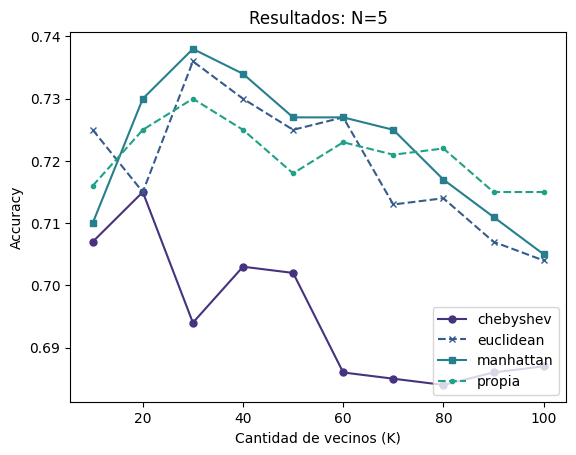

In [63]:
sns.set_palette("viridis")
for name in resultados_5_exp_transformado.groups.keys():
    group = resultados_5_exp_transformado.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=5")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

#### Visualización de resultados con 10 experimentos.

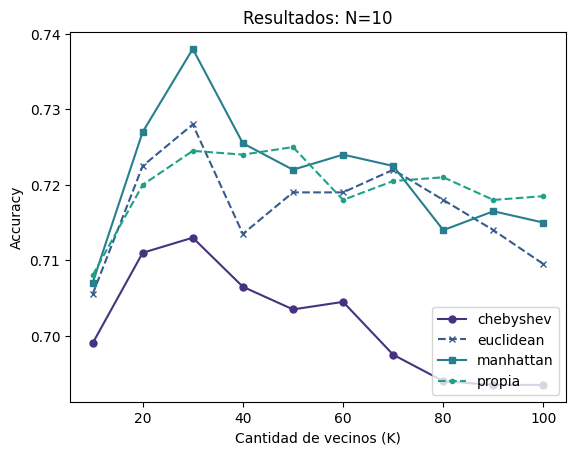

In [64]:
for name in resultados_10_exp_transformado.groups.keys():
    group = resultados_10_exp_transformado.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=10")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

#### Visualización de resultados con 20 experimentos.

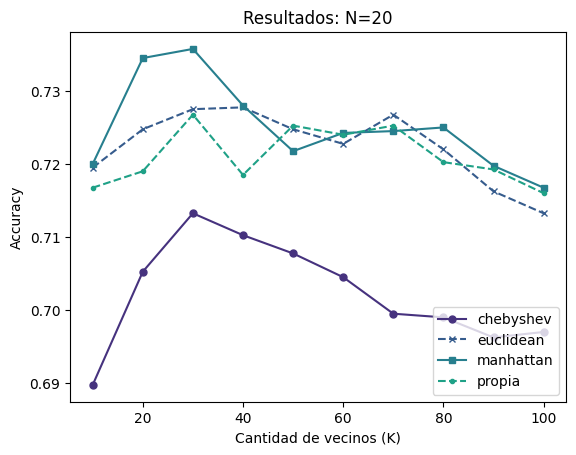

In [65]:
for name in resultados_20_exp_transformado.groups.keys():
    group = resultados_20_exp_transformado.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=20")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

#### Visualización de resultados con 30 experimentos.

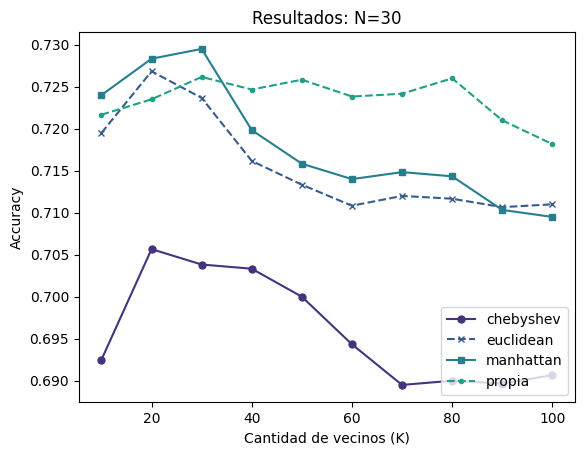

In [66]:
for name in resultados_30_exp_transformado.groups.keys():
    group = resultados_30_exp_transformado.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name)
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=30")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

### Mejores valores de K

Se presentan los valores de K con el "accuracy" mas alto

Mejor valor de K con 5 experimentos:

In [67]:
resultados_5_exp_transformado = resultados_5_exp_transformado.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_5_transformado  = resultados_5_exp_transformado.loc[resultados_5_exp_transformado['ACC'].idxmax()]
mejor_k_5_transformado  = fila_mejor_k_5_transformado['K']
mejor_acc_5_transformado  = fila_mejor_k_5_transformado['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_5_transformado }")
print(f"El mejor ACC es: {mejor_acc_5_transformado }")

El valor de K con el mejor ACC es: 30
El mejor ACC es: 0.738


In [68]:
resultados_10_exp_transformado = resultados_10_exp_transformado.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_10_transformado  = resultados_10_exp_transformado.loc[resultados_10_exp_transformado['ACC'].idxmax()]
mejor_k_10_transformado  = fila_mejor_k_10_transformado['K']
mejor_acc_10_transformado  = fila_mejor_k_10_transformado['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_10_transformado }")
print(f"El mejor ACC es: {mejor_acc_10_transformado }")

El valor de K con el mejor ACC es: 30
El mejor ACC es: 0.738


In [69]:
resultados_20_exp_transformado = resultados_20_exp_transformado.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_20_transformado  = resultados_20_exp_transformado.loc[resultados_20_exp_transformado['ACC'].idxmax()]
mejor_k_20_transformado  = fila_mejor_k_20_transformado['K']
mejor_acc_20_transformado  = fila_mejor_k_20_transformado['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_20_transformado }")
print(f"El mejor ACC es: {mejor_acc_20_transformado }")

El valor de K con el mejor ACC es: 30
El mejor ACC es: 0.73575


In [70]:
resultados_30_exp_transformado = resultados_30_exp_transformado.apply(lambda x: x.reset_index(drop=True))

# Obtener el valor de K con el mejor ACC
fila_mejor_k_30_transformado  = resultados_30_exp_transformado.loc[resultados_30_exp_transformado['ACC'].idxmax()]
mejor_k_30_transformado  = fila_mejor_k_30_transformado['K']
mejor_acc_30_transformado  = fila_mejor_k_30_transformado['ACC']

print(f"El valor de K con el mejor ACC es: {mejor_k_30_transformado }")
print(f"El mejor ACC es: {mejor_acc_30_transformado }")

El valor de K con el mejor ACC es: 30
El mejor ACC es: 0.7294999999999999


**Resumen resultados mejor K y Accuracy con datos transformados**

In [71]:
print("resumen mejores K y ACC")
print(f"Mejor K y acc con 5 experimentos: K= {mejor_k_5_transformado}, acc= {mejor_acc_5_transformado}")
print(f"Mejor K y acc con 10 experimentos: K= {mejor_k_10_transformado}, acc= {mejor_acc_10_transformado}")
print(f"Mejor K y acc con 20 experimentos: K= {mejor_k_20_transformado}, acc= {mejor_acc_20_transformado}")
print(f"Mejor K y acc con 30 experimentos: K= {mejor_k_30_transformado}, acc= {mejor_acc_30_transformado}")

resumen mejores K y ACC
Mejor K y acc con 5 experimentos: K= 30, acc= 0.738
Mejor K y acc con 10 experimentos: K= 30, acc= 0.738
Mejor K y acc con 20 experimentos: K= 30, acc= 0.73575
Mejor K y acc con 30 experimentos: K= 30, acc= 0.7294999999999999



### Mejor K para datos transformados

A partir de los resultados anteriores se selecciona el "mejor K": **K = 30** con un accuracy **ACC = 0.754**


### Modelo optimizado con el mejor K para datos transformados

Se entrena el modelo con el mejor K seleccionado (K=30) y con la mejor distancia: "manhattan"

In [72]:
#Construcción de modelo KNN
modelo_KNN_con_transformacion=KNeighborsRegressor(n_neighbors=30, metric='manhattan')
X_train, X_test, y_train, y_test = train_test_split(X_Transformado, Y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
modelo_KNN_con_transformacion.fit(X_train, y_train)
print('Modelo entrenado')

(800, 30) (800,)
(200, 30) (200,)
Modelo entrenado


### Predicción del modelo con transformación con el conjunto de Test

In [73]:
y_pred = modelo_KNN_con_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion.head(10)

,real,predicción clase
6,1,1.0
825,1,1.0
446,0,0.0
847,1,1.0
971,1,1.0
173,1,1.0
298,1,1.0
537,1,1.0
2,1,1.0
529,1,1.0


### Evaluación de la calidad del modelo KNN con transformación

Mean Absolute Error (MAE): 0.26
Mean Squared Error (MSE): 0.26
Root Mean Squared Error (RMSE): 0.5099
Accuracy: 0.74
Precision:  0.7557
Recall:  0.9366
F1: 0.8365
Matriz de confusión:
Verdaderos negativos:  15  Falsos positivos:  43  Falsos negativos:  9  Verdaderos positivos:  133


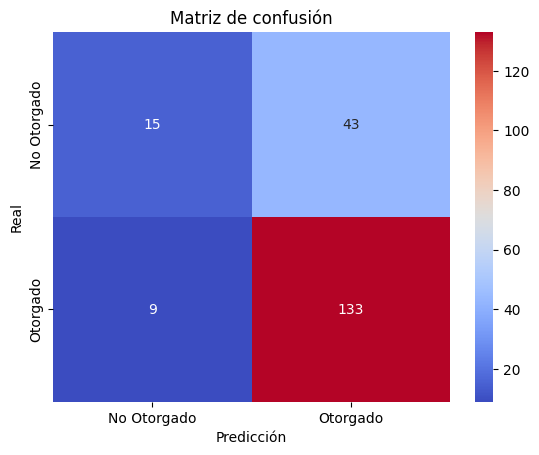

In [74]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

## 2.3 KNN con transformacion de variables y balanceo de datos

Si graficamos la varible objetivo de nuestro dataset podemos observar que hay un ""desbalance" en los datos.


<Axes: xlabel='TIPOCLIENTE', ylabel='count'>

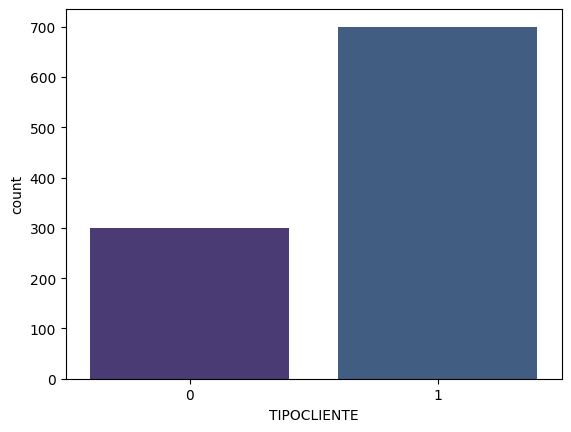

In [75]:
sns.countplot(x= Y)

Este desbalance puede ocasionar que nuestro modelo tenga problemas para identificar los clientes "malos" (0). Para solucionar esto, a continuación se aplican técnicas de balanceo de datos.

### Técnicas de balanceo de datos

A nuestro modelo optimizado con transformación de variables se le aplicará cuatro técnicas de balanceo.

In [76]:
dataframe_transformado_KNN.head()

,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,GARANTE_A103,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,0.0,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0


In [77]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss

from collections import Counter

#### Técnica de balanceo \#1: Ajuste de parametros; penalizacion en los pesos de la clase mayoritaria

In [78]:
X = copy.deepcopy(dataframe_transformado_KNN)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Utilizamos weights='distance' para aplicar penalización de pesos
modelo_KNN_con_transformacion_balanceado = KNeighborsRegressor(n_neighbors=30, metric='manhattan',weights='distance')

modelo_KNN_con_transformacion_balanceado.fit(X_train, y_train)

print("Modelo KNN con balanceo entrenado")

Modelo KNN con balanceo entrenado


##### Predicción del modelo con transformación y balanceo con el conjunto de Test: Técnica 1



In [79]:
y_pred = modelo_KNN_con_transformacion_balanceado.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion_balanceado_1=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion_balanceado_1.head(10)

,real,predicción clase
521,0,1.0
737,1,0.0
740,1,0.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,1.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad del modelo KNN con transformación y balanceo (1)

Mean Absolute Error (MAE): 0.27
Mean Squared Error (MSE): 0.27
Root Mean Squared Error (RMSE): 0.5196
Accuracy: 0.73
Precision:  0.7514
Recall:  0.922
F1: 0.828
Matriz de confusión:
Verdaderos negativos:  16  Falsos positivos:  43  Falsos negativos:  11  Verdaderos positivos:  130


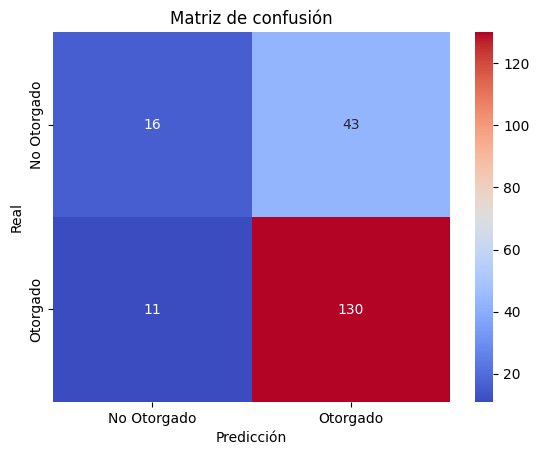

In [80]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#2: Subsampling en la clase mayoritaria

In [82]:
subsampling_knn = RandomUnderSampler(random_state=50)
X_train_sub, y_train_sub = subsampling_knn.fit_resample(X_train, y_train)

print ("Distribución antes del subsampling {}".format(Counter(y_train)))
print ("Distribución despues del subsampling {}".format(Counter(y_train_sub)))

modelo_KNN_con_transformacion.fit(X_train_sub, y_train_sub)

print("Modelo KNN balanceado entrenado")


Distribución antes del subsampling Counter({1: 559, 0: 241})
Distribución despues del subsampling Counter({0: 241, 1: 241})
Modelo KNN balanceado entrenado


##### Predicción del modelo con transformación y balanceo con el conjunto de Test: Técnica 2

In [83]:
y_pred = modelo_KNN_con_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion_balanceado_2=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion_balanceado_2.head(10)

,real,predicción clase
521,0,1.0
737,1,0.0
740,1,0.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,1.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad del modelo KNN con transformación y balanceo (2)

Mean Absolute Error (MAE): 0.305
Mean Squared Error (MSE): 0.305
Root Mean Squared Error (RMSE): 0.5523
Accuracy: 0.695
Precision:  0.8571
Recall:  0.6809
F1: 0.7589
Matriz de confusión:
Verdaderos negativos:  43  Falsos positivos:  16  Falsos negativos:  45  Verdaderos positivos:  96


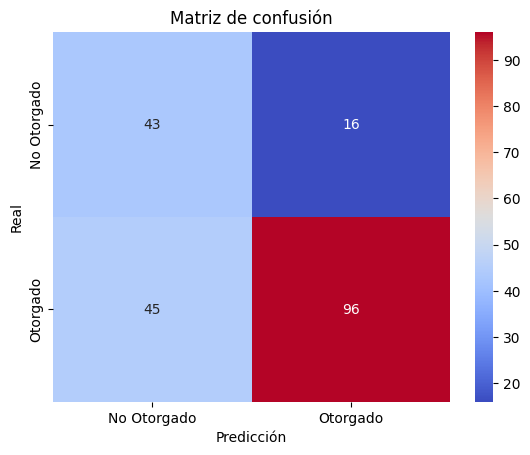

In [84]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#3: Oversampling en la clase minoritaria
En este caso, se crea muestras nuevas “sintéticas” de la clase minoritaria. Usando RandomOverSampler


In [85]:
oversampling_knn = RandomOverSampler(random_state=50)

X_train_over, y_train_over = oversampling_knn.fit_resample(X_train, y_train)

print ("Distribución antes del oversampling {}".format(Counter(y_train)))
print ("Distribución despues del oversampling {}".format(Counter(y_train_over)))

modelo_KNN_con_transformacion.fit(X_train_over, y_train_over)

print("Modelo KNN balanceado entrenado")

Distribución antes del oversampling Counter({1: 559, 0: 241})
Distribución despues del oversampling Counter({0: 559, 1: 559})
Modelo KNN balanceado entrenado


##### Predicción del modelo con transformación y balanceo con el conjunto de Test: Técnica 3

In [86]:
y_pred = modelo_KNN_con_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion_balanceado_3=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion_balanceado_3.head(10)

,real,predicción clase
521,0,0.0
737,1,0.0
740,1,0.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,0.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad del modelo KNN con transformación y balanceo (3)

Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.28
Root Mean Squared Error (RMSE): 0.5292
Accuracy: 0.72
Precision:  0.8455
Recall:  0.7376
F1: 0.7879
Matriz de confusión:
Verdaderos negativos:  40  Falsos positivos:  19  Falsos negativos:  37  Verdaderos positivos:  104


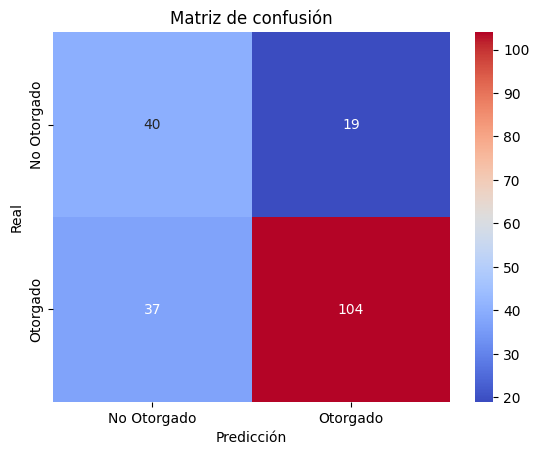

In [87]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#4: Smote-Tomek

La técnica de Smote-Tomek consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset

In [88]:
smote_tomek_knn = SMOTETomek(sampling_strategy=0.5)
X_train_smote, y_train_smote = smote_tomek_knn.fit_resample(X_train, y_train)

print ("Distribución antes de SMOTETOMEK {}".format(Counter(y_train)))
print ("Distribución despues de SMOTETOMEK {}".format(Counter(y_train_smote)))

modelo_KNN_con_transformacion.fit(X_train_smote, y_train_smote)

print("Modelo KNN balanceado entrenado")

Distribución antes de SMOTETOMEK Counter({1: 559, 0: 241})
Distribución despues de SMOTETOMEK Counter({1: 513, 0: 233})
Modelo KNN balanceado entrenado


##### Predicción del modelo con transformación y balanceo con el conjunto de Test: Técnica 4

In [89]:
y_pred = modelo_KNN_con_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion_balanceado_4=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion_balanceado_4.head(10)

,real,predicción clase
521,0,1.0
737,1,0.0
740,1,0.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,1.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad del modelo KNN con transformación y balanceo (4)

Mean Absolute Error (MAE): 0.25
Mean Squared Error (MSE): 0.25
Root Mean Squared Error (RMSE): 0.5
Accuracy: 0.75
Precision:  0.7725
Recall:  0.9149
F1: 0.8377
Matriz de confusión:
Verdaderos negativos:  21  Falsos positivos:  38  Falsos negativos:  12  Verdaderos positivos:  129


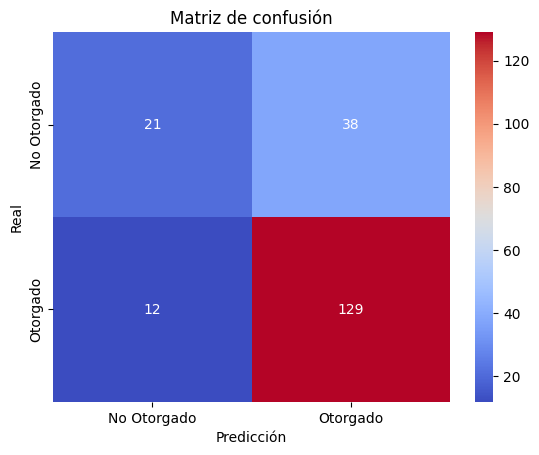

In [90]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#5: Ensamble de Modelos con Balanceo

Para esta técnica se usará un Clasificador de Ensamble que utiliza Bagging y el modelo será nuestro KNN


In [91]:
from sklearn.tree import DecisionTreeClassifier
bagging_classifier_knn = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
# Entrenar el modelo BalancedBaggingClassifier
bagging_classifier_knn.fit(X_train, y_train)
print("Modelo Ensemble entrenado")

Modelo Ensemble entrenado


##### Predicción del modelo con transformación y balanceo con el conjunto de Test: Técnica 5

In [92]:
y_pred = bagging_classifier_knn.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_KNN_con_transformacion_balanceado_5=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_KNN_con_transformacion_balanceado_5.head(10)

,real,predicción clase
521,0,0
737,1,0
740,1,0
660,1,1
411,1,1
678,1,0
626,1,1
513,1,0
859,1,1
136,1,0


##### Evaluación de la calidad del modelo KNN con transformación y balanceo (5)

Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.28
Root Mean Squared Error (RMSE): 0.5292
Accuracy: 0.72
Precision:  0.8632
Recall:  0.7163
F1: 0.7829
Matriz de confusión:
Verdaderos negativos:  43  Falsos positivos:  16  Falsos negativos:  40  Verdaderos positivos:  101


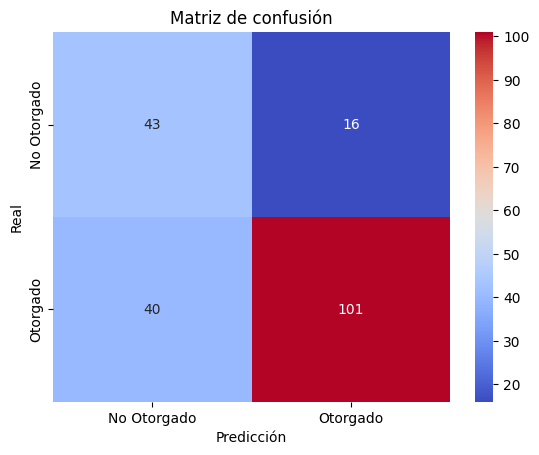

In [93]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### Mejor técnica de balanceo KNN
De acuerdo a los resultado anteriores la mejor técnica de balanceo para este Dataset y el modelo KNN es la técnica #4: **Smote-Tomek**

|Técnica| ACC| presicion| recall| F1-score|
|-------|-----|---------|--------|---------|
|Penalización|0.73|0.7514|0.922|0.828|  
|Subsampling|0.695|0.8571|0.6809|0.7589|
|Oversampling|0.72|0.8455|0.7376|0.7879|
|**Smote Tomek**|**0.75**|**0.7725**|**0.9149**|**0.8377**|
|Ensemble|0.72|0.8632|0.7163|0.7829|

## 3. Modelo Red Neuronal

### 3.1 Red Neuronal sin transformación de datos

Se entrena la red neuronal solo con los datos númericos, no se aplican transformaciones.


In [94]:
dataframe_datos_numericos.head()

,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


#### Diseño de la Red Neuronal para datos sin transformar

In [95]:
cantidad_variables_numericas = dataframe_datos_numericos.shape[1]

def build_model_sin_transformacion():
    model = Sequential()
    model.add(Dense(3, input_shape=(cantidad_variables_numericas,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

modelo_NN_sin_transformacion = build_model_sin_transformacion()



#### Entrenamiento de la Red Neuronal sin transformaciones

In [96]:
X_sin_transformacion = copy.deepcopy(dataframe_datos_numericos)
X_train, X_test, y_train, y_test = train_test_split(X_sin_transformacion, Y, test_size = 0.2)
modelo_NN_sin_transformacion.fit(X_train, y_train, epochs=90, batch_size=50, verbose=0)
print("Modelo NN sin transformacion entrenado")


Modelo NN sin transformacion entrenado


#### Predicción de la Red Neuronal sin transformación

In [97]:
y_pred = modelo_NN_sin_transformacion.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_sin_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_sin_transformacion.head(10)

7/7 [==============================] - 0s 2ms/step


,real,predicción clase
283,1,1.0
777,1,1.0
65,1,1.0
743,1,1.0
297,1,1.0
585,0,1.0
185,1,1.0
628,1,1.0
149,1,1.0
772,1,1.0


#### Evaluación de la calidad de la Red Neuronal sin transformación

Mean Absolute Error (MAE): 0.27
Mean Squared Error (MSE): 0.27
Root Mean Squared Error (RMSE): 0.5196
Accuracy: 0.73
Precision:  0.73
Recall:  1.0
F1: 0.8439
Matriz de confusión:
Verdaderos negativos:  0  Falsos positivos:  54  Falsos negativos:  0  Verdaderos positivos:  146


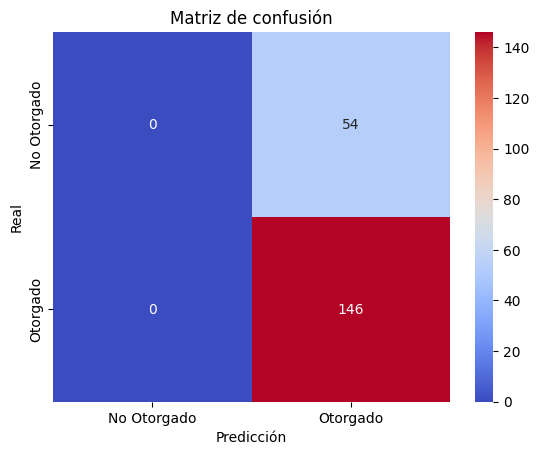

In [98]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### 3.2 Red Neuronal con transformación de datos

Usamos los transformadores ya definidos en la sección 2 y agregamos a un nuevo Pipeline

#### Diseño de pipeline
El procesador 'prepcn' es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline "pipe_nn" se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica

Se agrega el transformador de Estandarización: Preprocesador de variables numéricas con transformación StandardScaler

In [99]:
#Construcción de Pipeline para la red neuronal con transformadores
pipe_nn = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres),
    ('prepstandard', preprocesorStandardScaler)

])

pipe_nn

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

#### Transformación de variables

In [100]:
#Se ejecuta el pipeline
dataframe_transformado_NN=copy.deepcopy(dataframe)
X_Transformado = pipe_nn.fit_transform(dataframe_transformado_NN)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe_nn.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn"
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1]
    cnamesDataset2 = pipe_nn.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Cantidad de variables:', len(cnamesDataset1))
print('********** Lista de variables:')
print(cnamesDataset1)
dataframe_transformado_NN = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)

#Se agrega la variable de salida (etiquetas) al final
dataframe_transformado_NN = pd.concat([dataframe_transformado_NN, Y], axis = 1)

dataframe_transformado_NN.head()

********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['PROPOSITOCREDITO', 'GARANTE', 'TRABAJADOREXTRANJERO'])
********** Cantidad de variables: 30
********** Lista de variables:
['ESTADOCUENTACORRIENTE', 'HISTORIALCREDITO', 'SALDOCUENTAAHORROS', 'TIEMPOACTUALEMPLEO', 'ESTADOCIVILYSEXO', 'ACTIVOS', 'VIVIENDA', 'EMPLEO', 'PROPOSITOCREDITO_A40', 'PROPOSITOCREDITO_A41', 'PROPOSITOCREDITO_A410', 'PROPOSITOCREDITO_A42', 'PROPOSITOCREDITO_A43', 'PROPOSITOCREDITO_A44', 'PROPOSITOCREDITO_A45', 'PROPOSITOCREDITO_A46', 'PROPOSITOCREDITO_A48', 'PROPOSITOCREDITO_A49', 'GARANTE_A101', 'GARANTE_A102', 'GARANTE_A103', 'TRABAJADOREXTRANJERO_A201', 'TRABAJADOREXTRANJERO_A202', 'PLAZOMESESCREDITO', 'MONTOCREDITO', 'TASAPAGO', 'TIEMPORESIDENCIAACTUAL', 'EDAD', 'CANTIDADCREDITOSEXISTENTES', 'CANTIDADPERSONASAMANTENER']


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,-1.254566,1.344014,1.833169,1.338078,0.449326,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,1
1,-0.459026,-0.503428,-0.699707,-0.317959,-0.963650,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0
2,1.132053,1.344014,-0.699707,0.510060,0.449326,-1.293723,0.133710,-1.383771,-0.552705,-0.338862,...,0.196014,-0.196014,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,1
3,-1.254566,-0.503428,-0.699707,0.510060,0.449326,-0.341055,2.016956,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,1
4,-1.254566,0.420293,-0.699707,-0.317959,0.449326,1.564281,2.016956,0.146949,1.809283,-0.338862,...,0.196014,-0.196014,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0


#### Diseño de la Red Neuronal con transformación de datos

A continuación, creamos la Red Neuronal. Luego, agregamos el clasificador al final del Pipeline.

In [101]:
#Se identifica la cantidad de variables para crear la capa de entrada de la red neuronal
nombrePrep='prepstandard'#
cantidadVariablesIndependientesNN = len(pipe_nn.named_steps[nombrePrep].transformers_[0][2])
print("\nCantidad de variables después de preprocesamiento: ",cantidadVariablesIndependientesNN)


Cantidad de variables después de preprocesamiento:  30


Se tiene una red neuronal con una capa de entrada, dos capas ocultas y una capa de salida. Las capas ocultas tienen 30 neuronas, estas tienen la función de activación ReLU, y la capa de salida tiene una sola neurona con una función de activación sigmoide

In [126]:
def build_model_NN_con_transformacion_optimizado():
    model = Sequential()
    model.add(Dense(30, input_shape=(cantidadVariablesIndependientesNN,), activation='relu'))
    model.add(Dense(30, activation='relu'))  # Capa oculta adicional con 30 neuronas
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

modelo_NN_con_transformacion = build_model_NN_con_transformacion_optimizado()
print("Modelo de la Red Neuronal Creado")

#Se inserta el modelo como paso final del pipeline
pipe_nn.steps.append(['modelNN',modelo_NN_con_transformacion])
#pipe_nn.steps.pop()
print("Cantidad de pasos: ",len(pipe_nn.steps))
pipe_nn.named_steps['modelNN'].summary()


Modelo de la Red Neuronal Creado
Cantidad de pasos:  3
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 30)                930       
                                                                 
 dense_18 (Dense)            (None, 30)                930       
                                                                 
 dense_19 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1891 (7.39 KB)
Trainable params: 1891 (7.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamiento de la Red Neuronal con transformación de datos


In [127]:

X=copy.deepcopy(dataframe)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)#random_state = 0
pipe_nn.fit(X_train, y_train, modelNN__epochs=150, modelNN__batch_size=10, modelNN__verbose=0)

print('Modelo base entrenado')

Modelo base entrenado


#### Predicción con el conjunto de Test


In [129]:
y_pred = pipe_nn.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion.head(10)

7/7 [==============================] - 0s 2ms/step


,real,predicción clase
812,0,1.0
542,0,1.0
210,1,1.0
44,0,0.0
945,1,0.0
955,1,1.0
986,1,0.0
134,1,1.0
351,0,1.0
186,0,1.0


#### Evaluación de la calidad de la Red Neuronal con transformación

Mean Absolute Error (MAE): 0.335
Mean Squared Error (MSE): 0.335
Root Mean Squared Error (RMSE): 0.5788
Accuracy: 0.665
Precision:  0.7603
Recall:  0.7762
F1: 0.7682
Matriz de confusión:
Verdaderos negativos:  22  Falsos positivos:  35  Falsos negativos:  32  Verdaderos positivos:  111


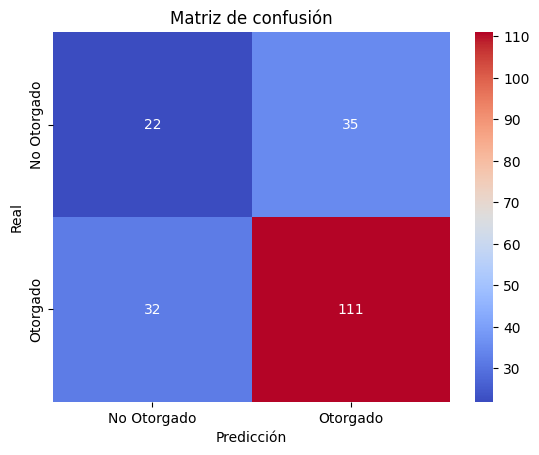

In [130]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### 3.3 Red neuronal con transformación y balanceo de datos

Se usa el Pipeline de la seccion 3.2 "pipe_nn"

#### Técnicas de balanceo de datos

A nuestro modelo de Red Neuronal optimizada con transformación de variables se le aplicará cuatro técnicas de balanceo.



#### Técnica de balanceo \#1: Ajuste de parametros; penalizacion en los pesos de la clase mayoritaria

In [131]:
from sklearn.utils import class_weight
X=copy.deepcopy(dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),y= y_train)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

pipe_nn.fit(X_train, y_train, modelNN__batch_size=10, modelNN__epochs=110, modelNN__verbose=0,modelNN__class_weight=class_weight_dict)

print('Modelo optimizado entrenado')

Modelo optimizado entrenado


##### Predicción con el conjunto de Test



In [132]:
y_pred = pipe_nn.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion.head(10)

7/7 [==============================] - 0s 1ms/step


,real,predicción clase
521,0,0.0
737,1,1.0
740,1,1.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,0.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad de la Red Neuronal con transformación y balanceo (1)

Mean Absolute Error (MAE): 0.16
Mean Squared Error (MSE): 0.16
Root Mean Squared Error (RMSE): 0.4
Accuracy: 0.84
Precision:  0.8516
Recall:  0.9362
F1: 0.8919
Matriz de confusión:
Verdaderos negativos:  36  Falsos positivos:  23  Falsos negativos:  9  Verdaderos positivos:  132


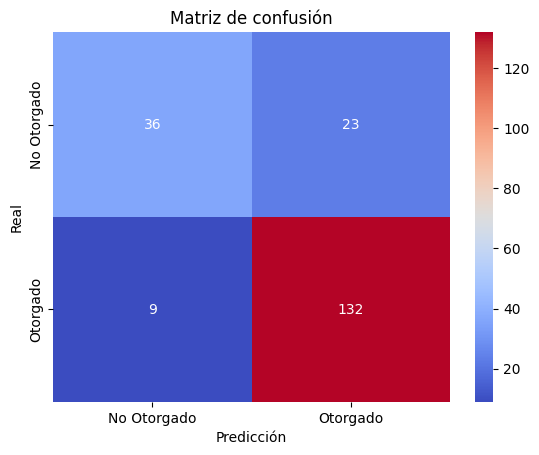

In [133]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#2: Subsampling en la clase mayoritaria

In [134]:
from imblearn.under_sampling import RandomUnderSampler

subsampling_balancer = RandomUnderSampler(random_state=50)

X_train_sub, y_train_sub = subsampling_balancer.fit_resample(X_train, y_train)

print ("Distribucion antes de subampling {}".format(Counter(y_train)))
print ("Distribucion despues de subampling {}".format(Counter(y_train_sub)))

pipe_nn.fit(X_train_sub, y_train_sub, modelNN__batch_size=10, modelNN__epochs=110, modelNN__verbose=0)

print("modelo entrenado técnica 2")

Distribucion antes de subampling Counter({1: 559, 0: 241})
Distribucion despues de subampling Counter({0: 241, 1: 241})
modelo entrenado técnica 2


##### Predición con el conjunto de Test

In [135]:
y_pred = pipe_nn.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion_balanceo=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion_balanceo.head(10)

7/7 [==============================] - 0s 1ms/step


,real,predicción clase
521,0,1.0
737,1,1.0
740,1,1.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,0.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad de la Red Neuronal con transformación y balanceo (2)

Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.4123
Accuracy: 0.83
Precision:  0.8591
Recall:  0.9078
F1: 0.8828
Matriz de confusión:
Verdaderos negativos:  38  Falsos positivos:  21  Falsos negativos:  13  Verdaderos positivos:  128


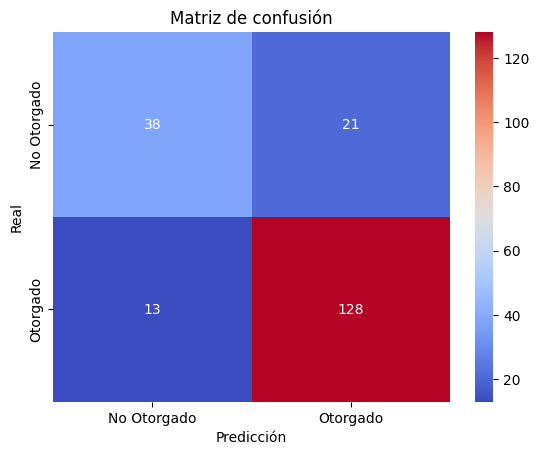

In [136]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#3: Oversampling en la clase minoritaria
En este caso, se crea muestras nuevas “sintéticas” de la clase minoritaria. Usando RandomOverSampler

In [137]:
from imblearn.over_sampling import RandomOverSampler

oversampling_balancer = RandomOverSampler(random_state=50)

X_train_over, y_train_over = oversampling_balancer.fit_resample(X_train, y_train)

print ("Distribucion antes de Oversampling {}".format(Counter(y_train)))
print ("Distribucion antes de Oversampling {}".format(Counter(y_train_over)))

pipe_nn.fit(X_train_over, y_train_over, modelNN__batch_size=10, modelNN__epochs=120, modelNN__verbose=0)

print("modelo entrenado técnica  3")

Distribucion antes de Oversampling Counter({1: 559, 0: 241})
Distribucion antes de Oversampling Counter({0: 559, 1: 559})
modelo entrenado técnica  3


##### Predición con el conjunto de Test

In [138]:
y_pred = pipe_nn.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion_balanceo=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion_balanceo.head(10)

7/7 [==============================] - 0s 1ms/step


,real,predicción clase
521,0,0.0
737,1,1.0
740,1,1.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,0.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad de la Red Neuronal con transformación y balanceo (3)

Mean Absolute Error (MAE): 0.175
Mean Squared Error (MSE): 0.175
Root Mean Squared Error (RMSE): 0.4183
Accuracy: 0.825
Precision:  0.8533
Recall:  0.9078
F1: 0.8797
Matriz de confusión:
Verdaderos negativos:  37  Falsos positivos:  22  Falsos negativos:  13  Verdaderos positivos:  128


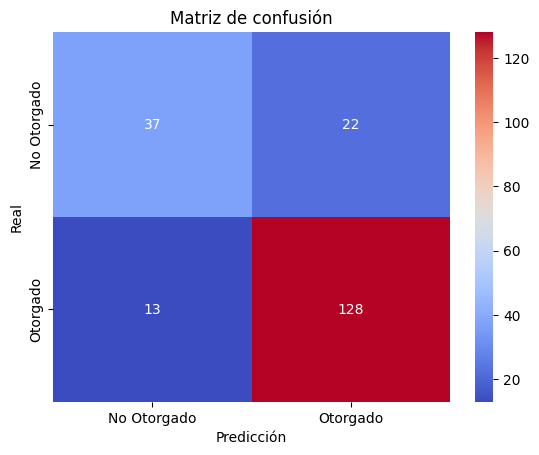

In [139]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

#### Técnica de balanceo \#4: Smote-Tomek

La técnica de Smote-Tomek consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset

In [141]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

dataframe_transformado_NN_sin_Y = dataframe_transformado_NN.iloc[:, :-1]

X = copy.deepcopy(dataframe_transformado_NN_sin_Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

tomek = TomekLinks()
X_train_balanced, y_train_balanced = tomek.fit_resample(X_train_resampled, y_train_resampled)

print ("Distribucion antes de SmoteTomek {}".format(Counter(y_train)))
print ("Distribucion antes de SmoteTomek {}".format(Counter(y_train_balanced)))

modelo_KNN_con_transformacion_balanceado_2 = build_model_NN_con_transformacion_optimizado()


modelo_KNN_con_transformacion_balanceado_2.fit(X_train_balanced, y_train_balanced, batch_size=10, epochs=120, verbose=0)

print("modelo entrenado técnica  4")


Distribucion antes de SmoteTomek Counter({1: 559, 0: 241})
Distribucion antes de SmoteTomek Counter({0: 559, 1: 547})
modelo entrenado técnica  4


##### Predición con el conjunto de Test

In [144]:
y_pred = modelo_KNN_con_transformacion_balanceado_2.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion_balanceo=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion_balanceo.head(10)

7/7 [==============================] - 0s 1ms/step


,real,predicción clase
521,0,0.0
737,1,0.0
740,1,1.0
660,1,1.0
411,1,1.0
678,1,1.0
626,1,1.0
513,1,0.0
859,1,1.0
136,1,1.0


##### Evaluación de la calidad de la Red Neuronal con transformación y balanceo (4)

Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.28
Root Mean Squared Error (RMSE): 0.5292
Accuracy: 0.72
Precision:  0.7891
Recall:  0.8227
F1: 0.8056
Matriz de confusión:
Verdaderos negativos:  28  Falsos positivos:  31  Falsos negativos:  25  Verdaderos positivos:  116


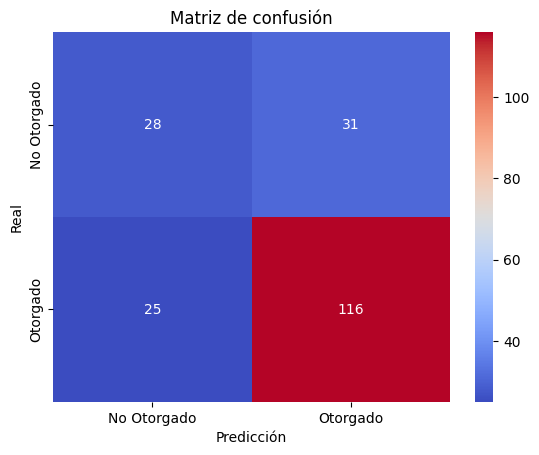

In [145]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### Mejor técnica de balanceo Red Neuronal
De acuerdo a los resultado anteriores la mejor técnica de balanceo para este Dataset y la Red Neuronal es la técnica #1: **Penalizacion en los pesos de la clase mayoritaria**

|Técnica| ACC| presicion| recall| F1-score|
|-------|-----|---------|--------|---------|
|Sin técnica|0.665|0.7603|0.7762|0.7682|  
|**Penalización**|**0.84**|**0.8516**|**0.9362**|**0.8919**|  
|Subsampling|0.83|0.8591|0.9078|0.8828|
|Oversampling|0.825|0.8533|0.9078|0.8797|
|Smote Tomek|0.72|0.7891|0.8227|0.8056|


## 4. Comparación de los modelos


| Modelo                                            | Accuracy | Precision | Recall | F1-Score |
|---------------------------------------------------|----------|-----------|--------|----------|
| KNN sin transformación y sin balanceo              | 0.68     | 0.6823    | 0.9776 | 0.8037   |
| Red Neuronal sin transformación y sin balanceo    | 0.73     | 0.73      | 1.0    | 0.8439   |
| KNN con transformación y selección de variables   | 0.755    | 0.7931    | 0.9139 | 0.8492   |
| Red Neuronal con transformación y selección de variables | 0.73     | 0.8067    | 0.8288 | 0.8176   |
| KNN con balanceo de datos                          | 0.75     | 0.7725    | 0.9149 | 0.8377   |
| **Red Neuronal con balanceo de datos**                 | **0.84**     | **0.8516**    | **0.9362** | **0.8919**   |


## 5. Predicción con el mejor modelo

Se carga el modelo con mejor resultado

In [146]:
X=copy.deepcopy(dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),y= y_train)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

pipe_nn.fit(X_train, y_train, modelNN__batch_size=10, modelNN__epochs=110, modelNN__verbose=0,modelNN__class_weight=class_weight_dict)

print('Modelo optimizado entrenado')

Modelo optimizado entrenado


Funciones para la predicción

In [147]:
#Esta es la función para calcular la certeza (confianza o probabilidad) asociada a la predicción de clase
def obtenerResultadosyCertezas(lista):
    predicciones=lista
    marcas=[]
    certezas=[]
    nuevomax=1
    nuevomin=0
    marca=-1
    certeza=-1
    for i in range(len(lista)):
        prediccion=lista[i]
        if (prediccion < 0.5):
            marca = 'No Otorgado'
            maxa=0.5
            mina=0
            certeza=1-((prediccion-mina)/(maxa-mina)*(nuevomax-nuevomin)+nuevomin)
            certeza=str(int((certeza)*100))+'%'
        elif (prediccion >= 0.5):
            marca = 'Otorgado'
            maxa=1
            mina=0.5
            certeza=(prediccion-mina)/(maxa-mina)*(nuevomax-nuevomin)+nuevomin
            certeza=str(int((certeza)*100))+'%'
        marcas.append(marca)
        certezas.append(certeza)
    return prediccion, marcas, certezas

def predecirNuevoCliente(ESTADOCUENTACORRIENTE='A12', PLAZOMESESCREDITO=6, HISTORIALCREDITO='A34', PROPOSITOCREDITO='A43',
                            MONTOCREDITO=1169, SALDOCUENTAAHORROS='A65', TIEMPOACTUALEMPLEO='A75', TASAPAGO=4,
                            ESTADOCIVILYSEXO='A93', GARANTE='A101', TIEMPORESIDENCIAACTUAL=4, ACTIVOS='A121', EDAD=67,
                            VIVIENDA='A152', CANTIDADCREDITOSEXISTENTES=2, EMPLEO='A173', CANTIDADPERSONASAMANTENER=2,
                            TRABAJADOREXTRANJERO='A201'):
    cnames=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
            'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
            'ACTIVOS','EDAD','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO','CANTIDADPERSONASAMANTENER',
            'TRABAJADOREXTRANJERO']
    Xnew=[ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,
          TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,
          CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO]
    Xnew_Dataframe = pd.DataFrame(data=[Xnew],columns=cnames)

    y_pred=pipe_nn.predict(Xnew_Dataframe)
    predicciones, marcas, certezas= obtenerResultadosyCertezas(y_pred)
    dataframeFinal_pred=pd.DataFrame({'Predicción':predicciones, 'Resultado':marcas, 'Certeza': certezas})
    np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
    return dataframeFinal_pred

### Predicción con nuevo cliente:

In [158]:
dataframe_nueva_prediccion=predecirNuevoCliente(ESTADOCUENTACORRIENTE='A11', PLAZOMESESCREDITO=30, HISTORIALCREDITO='A33', PROPOSITOCREDITO='A44',
                            MONTOCREDITO=13000, SALDOCUENTAAHORROS='A61', TIEMPOACTUALEMPLEO='A71', TASAPAGO=4,
                            ESTADOCIVILYSEXO='A93', GARANTE='A101', TIEMPORESIDENCIAACTUAL=10, ACTIVOS='A121', EDAD=28,
                            VIVIENDA='A151', CANTIDADCREDITOSEXISTENTES=2, EMPLEO='A171', CANTIDADPERSONASAMANTENER=0,
                            TRABAJADOREXTRANJERO='A201')
dataframe_nueva_prediccion.head()

1/1 [==============================] - 0s 22ms/step


,Predicción,Resultado,Certeza
0,0.999999,Otorgado,99%


In [157]:
dataframe_nueva_prediccion=predecirNuevoCliente(ESTADOCUENTACORRIENTE='A12', PLAZOMESESCREDITO=50, HISTORIALCREDITO='A33', PROPOSITOCREDITO='A44',
                            MONTOCREDITO=60000, SALDOCUENTAAHORROS='A61', TIEMPOACTUALEMPLEO='A71', TASAPAGO=4,
                            ESTADOCIVILYSEXO='A93', GARANTE='A101', TIEMPORESIDENCIAACTUAL=10, ACTIVOS='A121', EDAD=48,
                            VIVIENDA='A151', CANTIDADCREDITOSEXISTENTES=0, EMPLEO='A171', CANTIDADPERSONASAMANTENER=0,
                            TRABAJADOREXTRANJERO='A201')
dataframe_nueva_prediccion.head()

1/1 [==============================] - 0s 26ms/step


,Predicción,Resultado,Certeza
0,8.799842e-08,No Otorgado,99%


## Conclusiones

Para realizar una clasificación, tanto el método de KNN y redes neuronales son buenas elecciones, sin embargo, la decisión de cuál usar a la final depende de los datos y de lo que se quiera predecir o clasificar. En nuestro caso, se tiene un dataset de un Banco, cuyo objetivo es predecir si un cliente es bueno o malo para otorgarle un crédito, en este contexto, se busca la máxima precisión, ya que un fallo en nuestra predicción puede ocasionar perdidas al Banco.


A partir de las pruebas realizadas, se llega a la conclusión que el mejor método, para este caso, es una red neuronal, a la cual se le aplica un método de balanceo. Con el método de penalización de pesos, se ha conseguido tener un "Accuracy" y "Recall" bastante altos, lo cual garantiza que nuestro modelo es confiable para el Banco.



Cuando se busca optimizar redes neuronales, lo primero que se piensa es en aumentar el número de capas, pero no siempre resulta efectivo, como fue en este caso, al aumentar más capas el modelo no mejoro, pero al aumentar el número de entradas, se notó una mejora considerable. Al final el diseño de una red neuronal también depende de los datos.



## Referencias

Ortiz, I. R. H., PhD. (2023, November 15). Análisis y transformación de variables categóricas, clasificación y optimización (fine tuning) con redes neuronales - préstamos en instituciones bancarias - GenSciNet. GenSciNet. https://genscinet.com/variables-categoricas-redes-neuronales-prestamos/

Ortiz, I. R. H., PhD. (2023a, October 28). Transformación de variables categóricas, clasificación con K Nearest Neighbor (KNN), optimización y visualización de resultados - préstamos en instituciones bancarias - GenSciNet. GenSciNet. https://genscinet.com/transformacion-clasificacionknn/

Na, & Na. (2020, March 3). Clasificación con datos desbalanceados | Aprende Machine Learning. Aprende Machine Learning. https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/

UCI Machine Learning Repository. (n.d.). http://archive.ics.uci.edu/dataset/144/statlog+german+credit+data







